In [1]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import lsst.daf.persistence        as dafPersist

import lsst.afw.display            as afwDisplay
import lsst.afw.table              as afwTable

import lsst.afw.display.utils as afwDisplayUtils
import lsst.afw.image.utils as afwImageUtils

#### Load the high-level "tasks" that process the pixels

In [3]:
from lsst.pipe.tasks.characterizeImage import CharacterizeImageTask
from lsst.pipe.tasks.calibrate         import CalibrateTask
from lsst.meas.algorithms.detection    import SourceDetectionTask
from lsst.meas.deblender               import SourceDeblendTask
from lsst.meas.base                    import SingleFrameMeasurementTask

#### Load a version of psfex that implements our Psf object

In [4]:
import lsst.meas.extensions.psfex.psfexPsfDeterminer

#### Setup the displays (by default an interface to ds9)

In [5]:
disp  = afwDisplay.Display(1)
disp2 = afwDisplay.Display(2)

## Create the tasks

In [6]:
schema = afwTable.SourceTable.makeMinimalSchema()
algMetadata = dafBase.PropertyList()

config = CharacterizeImageTask.ConfigClass()
config.psfIterations = 1
if False:
    config.measurePsf.psfDeterminer.name = "pca"
else:
    config.measurePsf.psfDeterminer.name = "psfex"
    
charImageTask =         CharacterizeImageTask(None, config=config)

config = SourceDetectionTask.ConfigClass()
sourceDetectionTask =   SourceDetectionTask(schema=schema, config=config)

sourceDeblendTask =     SourceDeblendTask(schema=schema)

config = SingleFrameMeasurementTask.ConfigClass()
config.slots.apFlux = 'base_CircularApertureFlux_12_0'
sourceMeasurementTask = SingleFrameMeasurementTask(schema=schema, config=config,
                                                   algMetadata=algMetadata)

## Process the data

In [7]:
butler = dafPersist.Butler("/Volumes/RHLData/hsc-v13_0")

In [8]:
dataId = dict(visit=29352, ccd=50)
exposure = butler.get('calexp', dataId)

tab = afwTable.SourceTable.make(schema)

result = charImageTask.characterize(exposure)
psfCellSet = result.psfCellSet     # we'll look at this data structure later

result = sourceDetectionTask.run(tab, exposure)
sources = result.sources

sourceDeblendTask.run(exposure, sources)

sourceMeasurementTask.run(exposure, sources)

sources.writeFits("outputTable.fits")
exposure.writeFits("example1-out.fits")

Define a boolean array that tells us which objects are 'good'; in this case:
 - No saturated pixels near their centres
 - terminal objects that haven't been further deblended

In [9]:
sources = sources.copy(True)

good = np.logical_and.reduce([sources.get('base_PixelFlags_flag_saturatedCenter') == 0,
                              sources.get("deblend_nChild") == 0,
                              ])

#### Look at how well the aperture photometry agrees with the PSF measurements

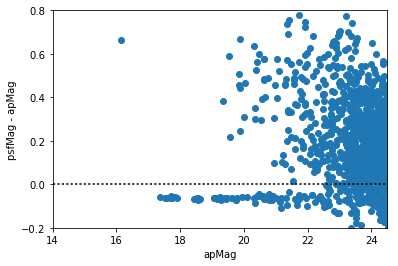

In [10]:
with afwImageUtils.CalibNoThrow():
    apMag = exposure.getCalib().getMagnitude(sources.getApFlux())
    psfMag = exposure.getCalib().getMagnitude(sources.getPsfFlux())

plt.plot(apMag[good], (psfMag - apMag)[good], 'o')

plt.axhline(0.0, ls=':', color='black')
plt.xlim(14, 24.5)
plt.ylim(-0.2, 0.8)

plt.xlabel("apMag")
plt.ylabel("psfMag - apMag")

plt.show()

#### Show the PSF candidates on the image

In [11]:
if True:
    disp2.mtv(exposure)
else:
    disp2.erase()

if psfCellSet:
    with disp2.Buffering():
        for cell in psfCellSet.getCellList():
            afwDisplayUtils.drawBBox(cell.getBBox(), display=disp2, 
                                     borderWidth=0.5, ctype=afwDisplay.CYAN)

            for cand in cell:
                disp2.dot("o", cand.getXCenter(), cand.getYCenter(), size=15,
                          ctype=afwDisplay.GREEN if cand.GOOD else afwDisplay.RED)

##### Look at the residuals from the PSF modelling

In [12]:
residuals = exposure.getMaskedImage().getImage().clone()
psf = exposure.getPsf()

with disp.Buffering():
    for s in sources[good]:
        psfImage = psf.computeImage(s.getCentroid()).convertF()
        psfImage *= s.getPsfFlux()/np.sum(psfImage.getArray())
            
        try:
            residuals[psfImage.getBBox()] -= psfImage
        except:
            pass
            
disp.mtv(residuals)

with disp.Buffering():
    for s in sources[good]:
        disp.dot("o", *s.getCentroid(), size=20) 

#### Fit a double-Gaussian approximtion to the PSF

In [172]:
def fitPsfAsDoubleGaussian(psf, position):
    """Return a double-Gaussian fit 

    Return:
      DoubleShapeletPsfApproxAlgorithm
      a list of(amplitude, sigma) for both components
    """
    import lsst.afw.geom as afwGeom
    import lsst.afw.geom.ellipses as afwEllipse
    from lsst.meas.modelfit import DoubleShapeletPsfApproxControl, DoubleShapeletPsfApproxAlgorithm
    from lsst.shapelet import ShapeletFunction 

    psfImage = psf.computeKernelImage(position)
    ctrl = DoubleShapeletPsfApproxControl()
    ctrl.innerOrder = 0
    ctrl.outerOrder = 0
    circularGaussians = 0
    result = DoubleShapeletPsfApproxAlgorithm.initializeResult(ctrl)
    DoubleShapeletPsfApproxAlgorithm.fitMoments(result, ctrl, psfImage)

    if circularGaussians:
        for comp in result.getComponents():
            roundCore = afwEllipse.Quadrupole()
            roundCore.scale(comp.getEllipse().getCore().getTraceRadius())
            comp.getEllipse().setCore(roundCore)

    DoubleShapeletPsfApproxAlgorithm.fitProfile(result, ctrl, psfImage)

    params = []
    for comp in result.getComponents():
        alpha = comp.getEllipse().getCore().getTraceRadius()
        params.append([comp.getCoefficients()[0]/ShapeletFunction.FLUX_FACTOR/(2*pi*alpha**2),
                       alpha])

    a0 = params[0][0]
    for p in params:
        p[0] /= a0
        
    return result, params

In [173]:
import lsst.afw.image as afwImage
import lsst.afw.math as afwMath

position = afwGeom.PointD(1000, 1000)
result, params = fitPsfAsDoubleGaussian(exposure.getPsf(), position)
print params

psfIm = exposure.getPsf().computeKernelImage(position)
im = afwImage.ImageD(psfIm.getBBox())
result.evaluate().addToImage(im)
    
im -= psfIm
afwDisplay.getDisplay(0).mtv(im)

[[1.0, 2.503092281190429], [0.27037680782676266, 5.402059442341348]]
